Setup

In [1]:
from pathlib import Path
import pandas as pd

# project root is the notebook's parent folder's parent
# adjust if your notebook lives elsewhere
PROJECT = Path.cwd().parents[0]
RAW = PROJECT / "data" / "raw"
PROC = PROJECT / "data" / "processed"
PROC.mkdir(parents=True, exist_ok=True)

RAW

WindowsPath('C:/Users/Admin/Desktop/Projects/turbofan-health-explorer/data/raw')

3.1 Verify raw files

In [2]:
# list expected files and assert they exist
expected = ["train_FD001.txt", "test_FD001.txt", "RUL_FD001.txt"]
present = {p.name for p in RAW.glob("*")}

missing = [f for f in expected if f not in present]
print("Found:", sorted(present))
if missing:
    raise FileNotFoundError(f"Missing files in data/raw: {missing}")
else:
    print("All expected FD001 files are present.")


Found: ['Damage Propagation Modeling.pdf', 'RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt', 'readme.txt', 'test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt', 'train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']
All expected FD001 files are present.


3.2 Load raw training file

In [3]:
train_file = RAW / "train_FD001.txt"

# read whitespace-separated text with no header row
# engine='python' handles irregular spacing
df_raw = pd.read_csv(
    train_file,
    sep=r"\s+",
    header=None,
    engine="python"
)

print("Shape:", df_raw.shape)
df_raw.iloc[:5, :8]


Shape: (20631, 26)


,0,1,2,3,4,5,6,7
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85


In [5]:
n_cols = df_raw.shape[1]
print("Column count detected:", n_cols)
if n_cols not in (26, 24):  # some subsets have fewer sensors
    print("Warning: unexpected column count. Continue, but confirm names next cell.")


Column count detected: 26


3.3 Assign schema

In [6]:
# For CMAPSS FD001: 26 columns total
# 2 identifiers (unit, cycle) + 3 operating settings (op1..op3) + sensors
id_cols = ["unit", "cycle"]
op_cols = [f"op{i}" for i in range(1, 4)]
sensor_count = n_cols - len(id_cols) - len(op_cols)
sensor_cols = [f"s{i}" for i in range(1, sensor_count + 1)]

col_names = id_cols + op_cols + sensor_cols
assert len(col_names) == n_cols, "Column name count does not match detected column count"

df_raw.columns = col_names

print("First columns:", df_raw.columns[:8].tolist())
print("Last columns:", df_raw.columns[-5:].tolist())
df_raw.head()


First columns: ['unit', 'cycle', 'op1', 'op2', 'op3', 's1', 's2', 's3']
Last columns: ['s17', 's18', 's19', 's20', 's21']


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


3.4.a sort and enforce dtypes

In [7]:
# start from the named DataFrame you created in 3.3
df = df_raw.sort_values(["unit", "cycle"]).reset_index(drop=True)

# build a dtype map: ints for ids, floats for ops and sensors
dtype_map = {"unit": "int32", "cycle": "int32"}
dtype_map.update({c: "float32" for c in ["op1", "op2", "op3"]})
dtype_map.update({c: "float32" for c in df.columns if c.startswith("s")})

df = df.astype(dtype_map)

# quick confirmation
df.info(show_counts=True)
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   unit    20631 non-null  int32  
 1   cycle   20631 non-null  int32  
 2   op1     20631 non-null  float32
 3   op2     20631 non-null  float32
 4   op3     20631 non-null  float32
 5   s1      20631 non-null  float32
 6   s2      20631 non-null  float32
 7   s3      20631 non-null  float32
 8   s4      20631 non-null  float32
 9   s5      20631 non-null  float32
 10  s6      20631 non-null  float32
 11  s7      20631 non-null  float32
 12  s8      20631 non-null  float32
 13  s9      20631 non-null  float32
 14  s10     20631 non-null  float32
 15  s11     20631 non-null  float32
 16  s12     20631 non-null  float32
 17  s13     20631 non-null  float32
 18  s14     20631 non-null  float32
 19  s15     20631 non-null  float32
 20  s16     20631 non-null  float32
 21  s17     20631 non-null  float32
 22

,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.669983,641.820007,1589.699951,1400.599976,14.62,...,521.659973,2388.020020,8138.620117,8.4195,0.03,392.0,2388.0,100.0,39.060001,23.419001
1,1,2,0.0019,-0.0003,100.0,518.669983,642.150024,1591.819946,1403.140015,14.62,...,522.280029,2388.070068,8131.490234,8.4318,0.03,392.0,2388.0,100.0,39.000000,23.423599
2,1,3,-0.0043,0.0003,100.0,518.669983,642.349976,1587.989990,1404.199951,14.62,...,522.419983,2388.030029,8133.229980,8.4178,0.03,390.0,2388.0,100.0,38.950001,23.344200
3,1,4,0.0007,0.0000,100.0,518.669983,642.349976,1582.790039,1401.869995,14.62,...,522.859985,2388.080078,8133.830078,8.3682,0.03,392.0,2388.0,100.0,38.880001,23.373899
4,1,5,-0.0019,-0.0002,100.0,518.669983,642.369995,1582.849976,1406.219971,14.62,...,522.190002,2388.040039,8133.799805,8.4294,0.03,393.0,2388.0,100.0,38.900002,23.404400


3.4.b check and handle duplicates

In [8]:
dup_count = df.duplicated(["unit", "cycle"]).sum()
print("Duplicate (unit, cycle) rows:", dup_count)

if dup_count > 0:
    df = df.drop_duplicates(["unit", "cycle"]).reset_index(drop=True)
    print("Duplicates removed. New shape:", df.shape)


Duplicate (unit, cycle) rows: 0


3.4.c per unit monotonicity check

In [9]:
# verify cycles increase within each unit
mono = df.groupby("unit")["cycle"].apply(lambda c: c.is_monotonic_increasing).all()
print("Cycles monotonic within each unit:", mono)

# peek at first and last rows for a couple of units
for u in [1, 5, 10]:
    d = df[df["unit"] == u]
    print(f"Unit {u} cycles: {int(d['cycle'].min())} to {int(d['cycle'].max())}")


Cycles monotonic within each unit: True
Unit 1 cycles: 1 to 192
Unit 5 cycles: 1 to 269
Unit 10 cycles: 1 to 222


3.5.a Select columns and save

In [10]:
from pathlib import Path

PROC.mkdir(parents=True, exist_ok=True)

# compact working set: ids, ops, and a handful of sensors
keep = ["unit", "cycle", "op1", "op2", "op3", "s2", "s3", "s4", "s7", "s8"]
df_small = df[keep].copy()

out_parquet = PROC / "train_FD001_small.parquet"
df_small.to_parquet(out_parquet, index=False)

# optional CSV if you want a human readable copy too
out_csv = PROC / "train_FD001_small.csv"
df_small.to_csv(out_csv, index=False)

print("Saved:", out_parquet.name, "and", out_csv.name)
df_small.head()

Saved: train_FD001_small.parquet and train_FD001_small.csv


,unit,cycle,op1,op2,op3,s2,s3,s4,s7,s8
0,1,1,-0.0007,-0.0004,100.0,641.820007,1589.699951,1400.599976,554.359985,2388.060059
1,1,2,0.0019,-0.0003,100.0,642.150024,1591.819946,1403.140015,553.750000,2388.040039
2,1,3,-0.0043,0.0003,100.0,642.349976,1587.989990,1404.199951,554.260010,2388.080078
3,1,4,0.0007,0.0000,100.0,642.349976,1582.790039,1401.869995,554.450012,2388.110107
4,1,5,-0.0019,-0.0002,100.0,642.369995,1582.849976,1406.219971,554.000000,2388.060059


3.5.b reload to verify

In [11]:
df_chk = pd.read_parquet(out_parquet)
print("Row count equal:", df_chk.shape[0] == df_small.shape[0])
print("Columns equal:", list(df_chk.columns) == keep)
df_chk.info()


Row count equal: True
Columns equal: True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   unit    20631 non-null  int32  
 1   cycle   20631 non-null  int32  
 2   op1     20631 non-null  float32
 3   op2     20631 non-null  float32
 4   op3     20631 non-null  float32
 5   s2      20631 non-null  float32
 6   s3      20631 non-null  float32
 7   s4      20631 non-null  float32
 8   s7      20631 non-null  float32
 9   s8      20631 non-null  float32
dtypes: float32(8), int32(2)
memory usage: 806.0 KB


3.6.a counts, missingness, basic stats

In [12]:
import numpy as np

n_rows = len(df)
n_units = df["unit"].nunique()
min_cycles = df.groupby("unit")["cycle"].min().min()
max_cycles = df.groupby("unit")["cycle"].max().max()

print(f"Rows: {n_rows}  Units: {n_units}  Min cycle: {min_cycles}  Max cycle: {max_cycles}")

# missing values
print("\nMissing values per column:")
print(df.isna().sum()[df.isna().sum() > 0])

# basic stats for a few columns
cols_to_describe = ["op1", "op2", "op3", "s2", "s3", "s4"]
df[cols_to_describe].describe().T


Rows: 20631  Units: 100  Min cycle: 1  Max cycle: 362

Missing values per column:
Series([], dtype: int64)


,count,mean,std,min,25%,50%,75%,max
op1,20631.0,-0.000009,0.002187,-0.008700,-0.001500,0.000000,0.001500,0.008700
op2,20631.0,0.000002,0.000293,-0.000600,-0.000200,0.000000,0.000300,0.000600
op3,20631.0,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
s2,20631.0,642.680908,0.500053,641.210022,642.325012,642.640015,643.000000,644.530029
s3,20631.0,1590.523071,6.131150,1571.040039,1586.260010,1590.099976,1594.380005,1616.910034
s4,20631.0,1408.933716,9.000605,1382.250000,1402.359985,1408.040039,1414.555054,1441.489990


3.6.b quick visual check for one unit and one sensor

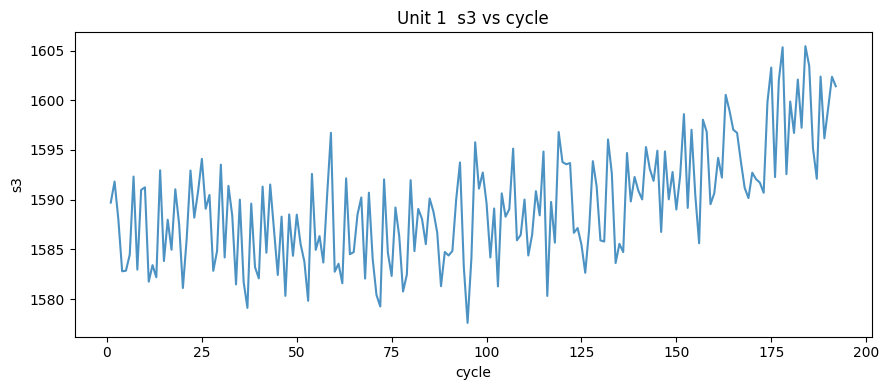

In [13]:
import matplotlib.pyplot as plt

unit_to_plot = 1
sensor_to_plot = "s3"

d = df[df["unit"] == unit_to_plot][["cycle", sensor_to_plot]]
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(d["cycle"], d[sensor_to_plot], alpha=0.8)
ax.set_title(f"Unit {unit_to_plot}  {sensor_to_plot} vs cycle")
ax.set_xlabel("cycle")
ax.set_ylabel(sensor_to_plot)
fig.tight_layout()
plt.show()


3.7 Data dictionary: write a simple data dictionary file

In [14]:
data_readme = PROJECT / "data" / "DATA_DESCRIPTION.md"

lines = [
"# CMAPSS FD001 Data Description\n",
"\nSource: NASA CMAPSS turbofan engine simulated data (FD001 subset)\n",
"Files: train_FD001.txt, test_FD001.txt, RUL_FD001.txt\n",
"Format: whitespace-separated text, no header row\n",
"\nColumns:\n",
"- unit  int  Engine identifier\n",
"- cycle  int  Cycle index within an engine trajectory\n",
"- op1  float  Operating setting 1\n",
"- op2  float  Operating setting 2\n",
"- op3  float  Operating setting 3\n",
"- s1..s21  float  Sensor measurements per cycle\n",
"\nTotals:\n",
"- 26 columns  2 identifiers, 3 operating settings, 21 sensors\n",
"\nProcessed small file saved to data/processed/train_FD001_small.parquet\n",
]
data_readme.write_text("".join(lines), encoding="utf-8")

print("Wrote", data_readme)


Wrote C:\Users\Admin\Desktop\Projects\turbofan-health-explorer\data\DATA_DESCRIPTION.md


Data Dictionary (Table)

Data Dictionary (Table)